In [1]:
# import tensorflow as tf
import pandas as pd
import sklearn
from datetime import datetime, timedelta

weather_df = pd.read_csv('weather_data.csv')
observations_df = pd.read_csv('observations.csv')

# convert datetime to same format as observations_df
weather_df['Datetime'] = pd.to_datetime(weather_df['Datetime'], format='%Y%m%d%H')
weather_df['Date'] = weather_df['Datetime'].dt.date

# Use same format as weather_df
observations_df['Date'] = pd.to_datetime(observations_df[['year', 'month', 'day']])

# Group by id and Date to find all unique days per ID
day_indices = weather_df.groupby(['id', 'Date']).first().reset_index()

# remove windspeed and specific humidity columns
day_indices = day_indices.drop(columns=['Wind Speed', 'Specific Humidity'])

# make dict of observation ID with original date
observation_dates = {}
for _, row in observations_df.iterrows():
    observation_dates[row['id']] = row['Date']

# Calculate difference between observation date and weather date
def get_relative_day(row):
    obs_date = observation_dates.get(row['id'])
    this_date = pd.to_datetime(row['Date'])
    difference = (this_date - obs_date).days
    return difference

# Apply the function to get relative day
day_indices['RelativeDay'] = day_indices.apply(get_relative_day, axis=1)

# Add relative day to weather_df
day_map = day_indices.set_index(['id', 'Date'])['RelativeDay']
weather_df['RelativeDay'] = weather_df.set_index(['id', 'Date']).index.map(day_map)

# Variables to calculate aggregations for
weather_vars = ['Temperature', 'Humidity','Dew/Frost Point', 
                'Wet Bulb Temperature', 'Precipitation', 'Soil Temperature']

# Time windows to aggregate over (days before and after the observation day)
time_windows = {
    'day_of': (0, 0),
    'day_before_after': (-1, 1),
    'three_days': (-3, 3),
    'one_week': (-7, 7),
    'two_weeks': (-14, 14)
}

# Function to calculate aggregates given ID and time window
def calculate_aggregates(weather_subset, var_name, window_name, start_day, end_day):
    # Filter data for given time window
    window_data = weather_subset[(weather_subset['RelativeDay'] >= start_day) & (weather_subset['RelativeDay'] <= end_day)]
    
    # Calculate aggregate and return as a series
    result = pd.Series({
        f"{var_name}_{window_name}_mean": window_data[var_name].mean(),
        f"{var_name}_{window_name}_min": window_data[var_name].min(),
        f"{var_name}_{window_name}_max": window_data[var_name].max(),
        f"{var_name}_{window_name}_median": window_data[var_name].median()
    })
    
    return result

# Create empty DataFrame to store results
all_features = []
result_rows = []

# For each observation row, calculate all aggregate weather data
for id_val in observations_df['id'].unique():
    id_weather = weather_df[weather_df['id'] == id_val]
        
    # Dictionary to store aggregated values for this ID
    id_features = {'id': id_val}
    
    # Iterate over all weather data variables
    for var in weather_vars:
        # iterate over all items in time_windows
        for window_name, (start_day, end_day) in time_windows.items():
            aggs = calculate_aggregates(id_weather, var, window_name, start_day, end_day)
            id_features.update(aggs)
            
            # Add feature names to our list (only once)
            if id_val == observations_df['id'].unique()[0]:
                all_features.extend(aggs.index.tolist())
    
    result_rows.append(id_features)

# Create DataFrame from results
aggregated_features = pd.DataFrame(result_rows)

# Merge with the original observations dataframe
observations_df = observations_df.merge(aggregated_features, on='id', how='left')

# Create list of feature names
weather_feature_names = all_features

print(f"Created {len(weather_feature_names)}  features")



# Add day of year as a feature to observations_df
observations_df['day_of_year'] = observations_df.apply(
    lambda row: datetime(row['year'], row['month'], row['day']).timetuple().tm_yday, 
    axis=1
)

# Drop rows with NaN values
observations_df = observations_df.dropna()

# Display the updated DataFrame
observations_df.head()
# Save the updated DataFrame to a new CSV file
observations_df.to_csv('observations_with_weather_features.csv', index=False)


Created 120  features


2025-04-21 23:49:45.263846: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/test/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5389 - loss: 5.2918 - val_accuracy: 0.4423 - val_loss: 3.1790
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5368 - loss: 5.1398 - val_accuracy: 0.5000 - val_loss: 3.2320
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6033 - loss: 3.7052 - val_accuracy: 0.5192 - val_loss: 1.5878
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4896 - loss: 3.2029 - val_accuracy: 0.4808 - val_loss: 1.3185
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5602 - loss: 2.4342 - val_accuracy: 0.6346 - val_loss: 1.2803
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5039 - loss: 2.4900 - val_accuracy: 0.5769 - val_loss: 1.3447
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4702 - loss: 2.3088 - val_accuracy: 0.5962 - val_loss: 1.6252
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5454 - loss: 1.6431 - val_accuracy: 0.5577 - val_loss: 1.2147


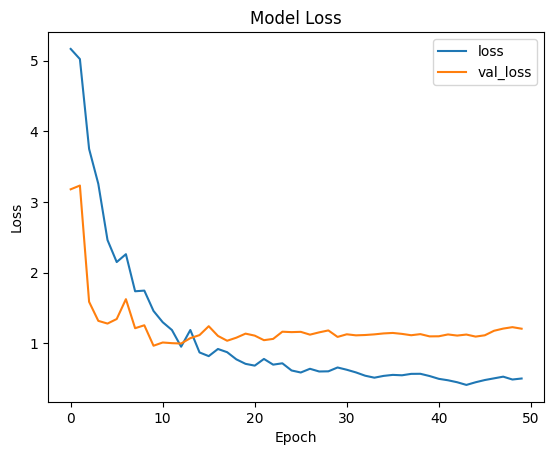

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 


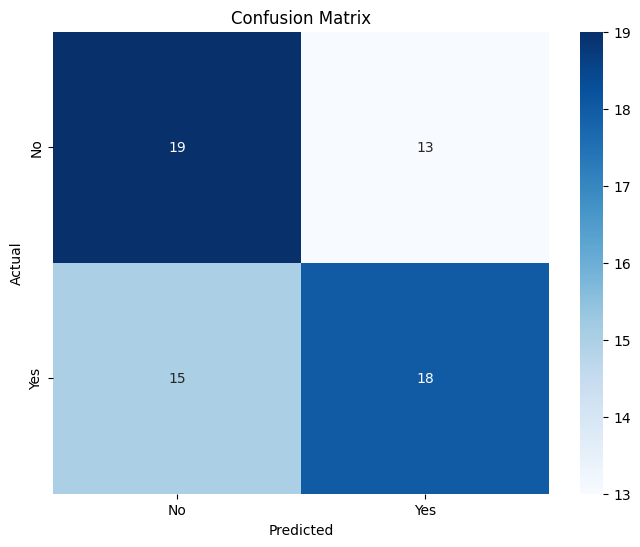

              precision    recall  f1-score   support

          No       0.56      0.59      0.58        32
         Yes       0.58      0.55      0.56        33

    accuracy                           0.57        65
   macro avg       0.57      0.57      0.57        65
weighted avg       0.57      0.57      0.57        65



In [2]:
from sklearn.model_selection import train_test_split

import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random


# set random seed for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


# Define the features and target variable
features = weather_feature_names + ['day_of_year']
target = 'PowderyMildew'

X = observations_df[features]
y = observations_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(len(features),)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation ='sigmoid')  # Output layer
])
# Compile the model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
# Plot training history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# Save the model
model.save('powdery_mildew_model.h5')
# Load the model
loaded_model = tf.keras.models.load_model('powdery_mildew_model.h5')
# Make predictions
predictions = loaded_model.predict(X_test)
# Display predictions
predictions_df = pd.DataFrame({'Predicted': predictions.flatten(), 'Actual': y_test})
predictions_df.head()

# test and output confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
# Convert predictions to binary classification
threshold = 0.5
y_pred_binary = (predictions.flatten() > threshold).astype(int)
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Print classification report
print(classification_report(y_test, y_pred_binary, target_names=['No', 'Yes']))


Use 4 thread(s) for training
Use /var/folders/m6/mwqf242s2x36_c6nzj015lym0000gn/T/tmphhta7ee3 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'id': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'longitude': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'latitude': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'year': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'month': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'day': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Temperature_day_of_mean': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, 'Temperature_day_of_min': <tf.Tensor 'data_7:0' shape=(None,) dtype=float64>, 'Temperature_day_of_max': <tf.Tensor 'data_8:0' shape=(None,) dtype=float64>, 'Temperature_day_of_median': <tf.Tensor 'data_9:0' shape=(None,) dtype=float64>, 'Temperature_day_before_after_mean': <tf.Tensor 'data_10:0' shape=(None,) dtype=float64>, 'Temperature_day_before_after_min': <tf.Tensor

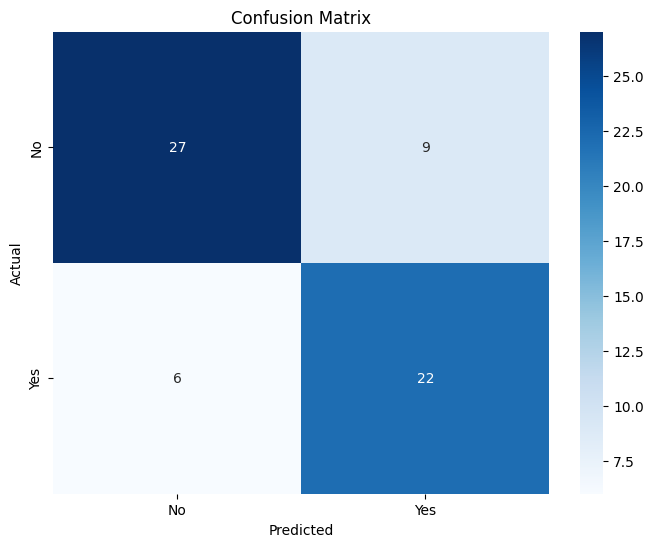

              precision    recall  f1-score   support

          No       0.82      0.75      0.78        36
         Yes       0.71      0.79      0.75        28

    accuracy                           0.77        64
   macro avg       0.76      0.77      0.76        64
weighted avg       0.77      0.77      0.77        64



INFO:tensorflow:Assets written to: powdery_mildew_model_decision_tree/assets


INFO:tensorflow:Assets written to: powdery_mildew_model_decision_tree/assets


In [3]:
# train a decision tree classifier
import tensorflow_decision_forests as tfdf

# set random seed for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

observations_df = pd.read_csv('observations_with_weather_features.csv')
# split df into train and test
train=observations_df.sample(frac=0.8,random_state=200)
test=observations_df.drop(train.index)

train.drop(columns=['Date', 'coordinates', 'date_string'], inplace=True)
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label="PowderyMildew")

test.drop(columns=['Date', 'coordinates', 'date_string'], inplace=True)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label="PowderyMildew")

tuner = tfdf.tuner.RandomSearch(num_trials=50)

tuner.choice("min_examples", [2, 5, 7, 10])
tuner.choice("categorical_algorithm", ["CART", "RANDOM"])

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [3, 4, 5, 6, 8])

# merge=True indicates that the parameter (here "growing_strategy") is already
# defined, and that new values are added to it.
global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [16, 32, 64, 128, 256])

tuner.choice("num_candidate_attributes_ratio", [0.2, 0.5, 0.9, 1.0])


# Create the model
model = tfdf.keras.RandomForestModel(verbose=2,tuner=tuner)
# Train the model
model.compile(metrics=["accuracy"])
model.fit(train_ds)
# Evaluate the model
evaluation = model.evaluate(test_ds)
print(evaluation)
# Make predictions
predictions = model.predict(test_ds)
# Convert predictions to binary classification
threshold = 0.5
y_pred_binary = (predictions.flatten() > threshold).astype(int)
# Generate confusion matrix
cm = confusion_matrix(test['PowderyMildew'], y_pred_binary)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Print classification report
print(classification_report(test['PowderyMildew'], y_pred_binary, target_names=['No', 'Yes']))

# save model
model.save("powdery_mildew_model_decision_tree")




Use /var/folders/m6/mwqf242s2x36_c6nzj015lym0000gn/T/tmp9slm9_w3 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'id': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'longitude': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'latitude': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'year': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'month': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'day': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Temperature_day_of_mean': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, 'Temperature_day_of_min': <tf.Tensor 'data_7:0' shape=(None,) dtype=float64>, 'Temperature_day_of_max': <tf.Tensor 'data_8:0' shape=(None,) dtype=float64>, 'Temperature_day_of_median': <tf.Tensor 'data_9:0' shape=(None,) dtype=float64>, 'Temperature_day_before_after_mean': <tf.Tensor 'data_10:0' shape=(None,) dtype=float64>, 'Temperature_day_before_after_min': <tf.Tensor 'data_11:0' shape=(None,) dt

[WARNING 25-04-21 23:51:13.0838 PDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 25-04-21 23:51:13.0838 PDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 25-04-21 23:51:13.0839 PDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Normalized tensor features:
 {'id': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'longitude': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'latitude': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'year': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_3:0' shape=(None,) dtype=float32>), 'month': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_4:0' shape=(None,) dtype=float32>), 'day': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_5:0' shape=(None,) dtype=float32>), 'Temperature_day_of_mean': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_6:0' shape=(None,) dtype=float32>), 'Temperature_day_of_min': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_7:0' shape=(None,) dtype=flo

1/1 [==============================] - 0s 236ms/step


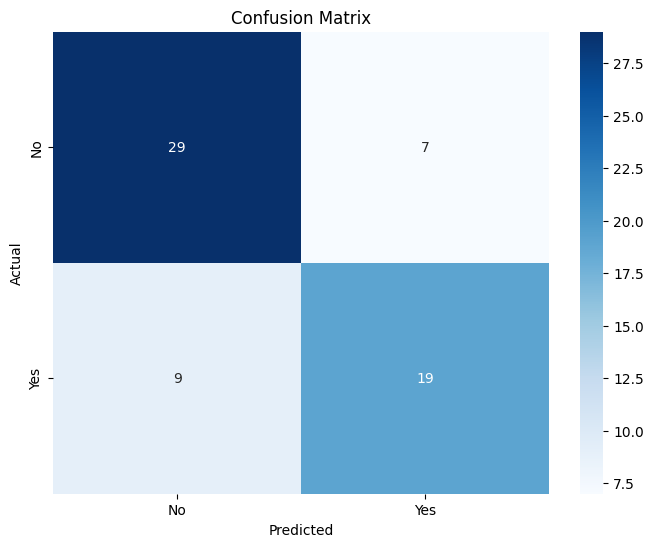

              precision    recall  f1-score   support

          No       0.76      0.81      0.78        36
         Yes       0.73      0.68      0.70        28

    accuracy                           0.75        64
   macro avg       0.75      0.74      0.74        64
weighted avg       0.75      0.75      0.75        64

INFO:tensorflow:Assets written to: gradient_boosted_model/assets


INFO:tensorflow:Assets written to: gradient_boosted_model/assets


In [4]:
# train a decision tree classifier
import tensorflow_decision_forests as tfdf

# set random seed for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

observations_df = pd.read_csv('observations_with_weather_features.csv')
# split df into train and test
train=observations_df.sample(frac=0.8,random_state=200)
test=observations_df.drop(train.index)

train.drop(columns=['Date', 'coordinates', 'date_string'], inplace=True)
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label="PowderyMildew")

test.drop(columns=['Date', 'coordinates', 'date_string'], inplace=True)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label="PowderyMildew")

# Create a Random Search tuner with 50 trials and automatic hp configuration.
tuner = tfdf.tuner.RandomSearch(num_trials=50, use_predefined_hps=True)

# Define and train the model.
model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
model.fit(train_ds, verbose=2)

# Train the model
model.compile(metrics=["accuracy"])
model.fit(train_ds)
# Evaluate the model
evaluation = model.evaluate(test_ds)
print(evaluation)
# Make predictions
predictions = model.predict(test_ds)
# Convert predictions to binary classification
threshold = 0.5
y_pred_binary = (predictions.flatten() > threshold).astype(int)
# Generate confusion matrix
cm = confusion_matrix(test['PowderyMildew'], y_pred_binary)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Print classification report
print(classification_report(test['PowderyMildew'], y_pred_binary, target_names=['No', 'Yes']))

# Save the model
model.save('gradient_boosted_model')